In [15]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam
from grid_cells import GridCells
from utils import get_coords, to_tensor, get_loc_batch
from agent import RMSprop
from tqdm import tqdm

In [2]:
def eval_position(agent, size=4096):
    losses = list()
    for _ in range(size // 256):
        x, y = get_loc_batch(c, gc, bs=256)
        x = agent.actor(x)[1]
        loss = torch.sum((x - y)**2).detach().cpu().numpy()
        losses.append(loss)
    return np.mean(losses)

In [3]:
resolution = 400
MIN, MAX = -1, 1
N = 100
scales = np.linspace(90, 300, 10, dtype=int)

coords = get_coords(resolution, MIN, MAX)
gcs = GridCells(scales, n_per_module=N, res=resolution)
gcs.reset_modules(1)
gcs.compile_numpy()
grid_cells = gcs.grid_cells.transpose(1, 2, 0)
c, gc = to_tensor(coords), to_tensor(grid_cells)

In [42]:
hidden = 500
wd_l1 = 1e-4
agent = Agent(grid_cells.shape[-1], 2, actor_hidden=hidden, lr_a=1e-4)
net = agent.actor
optim = RMSprop([p for p in net.parameters()], lr=1e-4)

In [51]:
# losses = list()
for _ in tqdm(range(30000)):
    optim.zero_grad()
    x, y = get_loc_batch(c, gc, bs=256)
    _, pred, h = net(x)
    loss = torch.sum((pred - y)**2, dim=-1).mean()
    loss += torch.sum(h, dim=-1).mean() / 50
    loss += net.normalization_loss() * wd_l1
    loss.backward()
    optim.step()
    losses.append(loss.detach().cpu().item())

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [11:42<00:00, 42.73it/s]


In [ ]:
net.lin1.weight.exp()[0].sum()

In [61]:
net.normalization_loss() * wd_l1

tensor(0.1606, device='cuda:0', grad_fn=<MulBackward0>)

In [67]:
net.lin1.bias.abs().mean()

tensor(3.2114, device='cuda:0', grad_fn=<MeanBackward0>)

In [53]:
net.transform_weights(net.lin1.weight).sum()

tensor(0.0002, device='cuda:0', grad_fn=<SumBackward0>)

Position loss: 170.746


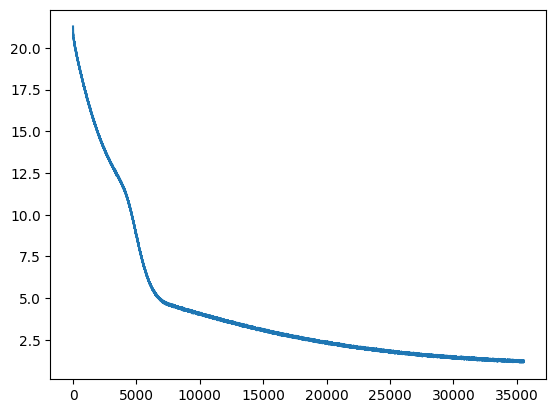

In [52]:
print(f"Position loss: {eval_position(agent):.03f}")
plt.plot(losses)
plt.show()

In [ ]:
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [hidden]]
print(net.lin2.weight[2:].detach().cpu().flatten()[idx.flatten()])

In [ ]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = nn.functional.sigmoid(net.lin1(gc)).permute((-1, 0, 1)).detach().cpu().numpy()
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
for img in hidden:
    plt.contourf(img, levels=20, cmap='hot')
    plt.axis('off')
    plt.tight_layout()
    plt.show()